In [1]:
from pulp import *
import numpy as np
import time
import itertools
from gurobipy import *

from sklearn.datasets import make_spd_matrix
import pandas as pd
from cvxopt import matrix, solvers

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set(font_scale=1.5, rc={'text.usetex' : True})

from math import sqrt
from cvxopt import matrix
from cvxopt.blas import dot
import cvxopt
import pylab
import random
from scipy.stats import gumbel_r

random.seed(123)

/Users/denghaonan/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## H-max Heuristic Based on Nested Logit Model

In [101]:
class Variants_NLM:
    
    def __init__(self,m_nests,n_prod):
        self.n = n_prod
        self.m = m_nests

        #self.mean_utilities = np.zeros((self.m,self.n+1))
        self.fixed_utility = np.zeros((self.m,self.n+1))    
        self.revenue = np.zeros((self.m,self.n+1))    
        self.gammas = np.zeros(self.m)
        self.weights = np.zeros((self.m,self.n+1))
        self.nest_by_revenue_sets = np.zeros((self.n,self.n))
        self.assortment_chosen_matrix = np.zeros((self.m,self.n))
  
        
        self.generate_utilities()
        self.generate_revenues()
        self.calculate_normalized_gamma()
        self.generate_weights()
        self.generate_nest_by_revenue()
    
  
    ###################### Generating Parameters ######################
    # Utilities follow Gumbel distribution with specified parameters
    def generate_utilities(self):
        gamma = 0.57721
        phi = np.pi / np.sqrt(6)
        nu = 10 - gamma / phi
        self.fixed_utility = np.round(gumbel_r.rvs(loc=nu, scale=1/phi, size=(self.m, self.n + 1)), 4)
    
    # revenues of products are assume to satisfy: revenue[i] >= revenue[i+1] for i=1,...,n, revenue[0]=0
    def generate_revenues(self):
        for i in range(self.m):
            random_revenues = np.random.rand(self.n)
            sorted_revenues = -np.sort(-random_revenues)  
            self.revenue[i, 1:] = sorted_revenues  
 

    # Gamma could be the standard deviation of utilities (after scaled)
    def calculate_normalized_gamma(self):
        gammas = []
        max_gamma = 0

        for utilities in self.fixed_utility:
            gamma = np.std(utilities)
            gammas.append(gamma)
            if gamma > max_gamma:
                max_gamma = gamma

        if max_gamma == 0:
            self.gammas = [0] * len(gammas)

        normalized_gammas = [gamma / max_gamma for gamma in gammas]
        self.gammas = normalized_gammas
    
    def generate_weights(self):
        for i in range(self.m):
            for j in range(0,self.n+1):
                self.weights[i][j] = np.exp(self.fixed_utility[i][j] / self.gammas[i])    # 这里做出了改变
            self.weights[i] = np.divide(self.weights[i], np.sum(self.weights[i]))


    ###################### Generating Product Sets ######################
    # Generate all the m*n choosing set (nest by revenue)
    def generate_nest_by_revenue(self): 
        valid_row_combinations = [[1] * i + [0] * (self.n - i) for i in range(self.n + 1)]
        all_combinations = list(itertools.product(valid_row_combinations, repeat=self.m))
        matrices = [np.vstack(combination) for combination in all_combinations]
        return matrices
    
    def generate_nest_by_revenue_nestcap(self, capacity):
        valid_row_combinations = [combination for combination in [[1] * i + [0] * (self.n - i) for i in range(self.n + 1)] if sum(combination) <= capacity]
        all_combinations = list(itertools.product(valid_row_combinations, repeat=self.m))
        matrices = [np.vstack(combination) for combination in all_combinations]
        return matrices
    
    def generate_nest_by_revenue_globalcap(self, capacity):
        valid_row_combinations = [[1] * i + [0] * (self.n - i) for i in range(self.n + 1)]
        all_combinations = list(itertools.product(valid_row_combinations, repeat=self.m))
        matrices = [np.vstack(combination) for combination in all_combinations if np.sum(combination) <= capacity]
        return matrices
    
    # Generate all the m*n choosing matrices 
    def generate_all_subsets(self): 
        all_combinations = itertools.product([0, 1], repeat=self.m * self.n)
        matrices = [np.array(combination).reshape(self.m, self.n) for combination in all_combinations]
        return matrices
    
    def generate_all_subsets_nestcap(self, capacity):
        all_combinations = itertools.product([0, 1], repeat=self.m * self.n)
        matrices = []
        for combination in all_combinations:
            matrix = np.array(combination).reshape(self.m, self.n)
            if all(np.sum(matrix[i]) <= capacity for i in range(self.m)):
                matrices.append(matrix)
        return matrices
    
    def generate_all_subsets_globalcap(self, capacity):
        all_combinations = itertools.product([0, 1], repeat=self.m * self.n)
        matrices = []
        for combination in all_combinations:
            matrix = np.array(combination).reshape(self.m, self.n)
            if np.sum(matrix) <= capacity:
                matrices.append(matrix)
        return matrices
    
    
    ###################### Calculating Latent Variables ######################
    # Generate the weight of nest i
    def V_i(self, i, x_i):
        return np.sum(self.weights[i][1:] * x_i)
    
    # Generate the expected revenue (given nest i)
    def R_i(self, i, x_i):
        V_i_value = self.V_i(i, x_i)
        return np.sum(self.revenue[i][1:] * self.weights[i][1:] * x_i) / V_i_value if V_i_value != 0 else 0

    # Generate the expected revenue (given decision matrix)
    def generate_expected_revenue(self, x):
        v0 = np.sum(self.weights[:, 0])
        numerator = 0
        denominator = v0
        for i in range(self.m):
            V_i_value = self.V_i(i, x[i])
            numerator += self.R_i(i, x[i]) * V_i_value ** self.gammas[i]
            denominator += V_i_value ** self.gammas[i]
        return numerator / denominator if denominator != 0 else 0
    
    # Given deicision matrix x, probability of choosing nest i
    def generate_between_nest_probability(self,i,x):      
        nominator = (self.V_i(i,x[i])) ** self.gammas[i]
        denominator = self.weights[:, 0].sum()
        for l in range(self.m):
            denominator += (self.V_i(l,x[l])) ** self.gammas[l]
        return nominator/denominator
    
    # Given decision matrix x, probability of not choosing any nest
    def generate_between_nest_no_purchase_probability(self,x):
        tmp = 0
        for i in range(self.m):
            tmp += self.generate_between_nest_probability(i,x)
        return 1-tmp

    # Given deicision matrix x and nest i，probability of choosing product j 
    def generate_within_nest_probability(self,i,j,x):    # j ranges from [1,n+1]
        nominator = self.weights[i][j] * x[i][j-1]
        denominator = self.weights[i][0] + self.V_i(i,x[i])
        return nominator/denominator
    
    # Given deicision matrix x and nest i，probability of not choosing any products
    def generate_within_nest_no_purchase_probability(self,i,x):
        nominator = self.weights[i][0] 
        denominator = self.weights[i][0] + self.V_i(i,x[i])
        return nominator/denominator
    
    def generate_odd_ratios_ij(self,i,j,x):
        return self.generate_within_nest_probability(i,j,x) / self.generate_within_nest_no_purchase_probability(i,x)
    
    def generate_lambda_i0(self,i):   
        N = np.ones((self.m,self.n))
        return self.generate_within_nest_no_purchase_probability(i,N)
    
    def generate_lambda_ij(self,i,j):      
        N = np.ones((self.m,self.n))
        return self.generate_within_nest_probability(i,j,N)

    def generate_omega_ij(self,i,j):     
        set_j = np.zeros((self.m,self.n))
        set_j[:,j-1] = 1
        return self.generate_within_nest_probability(i,j,set_j)
        
    def generate_a_ij(self,i,j):
        return self.generate_lambda_ij(i,j) / (1-self.generate_omega_ij(i,j))

    def generate_c_ij(self,i,j):
        return self.generate_omega_ij(i,j) / self.generate_lambda_i0(i)
    
    def generate_matrix_a(self):
        matrix_a = []
        for i in range(self.m):
            vector_a = []
            for j in range(1,self.n+1):
                vector_a.append(self.generate_a_ij(i,j))
            matrix_a.append(vector_a)
        return matrix_a 
    
    def generate_matrix_b(self):
        N = np.ones((self.m,self.n))
        matrix_b = []
        for i in range(self.m):
            vector_b = []
            for j in range(1,self.n+1):
                vector_b.append(self.generate_odd_ratios_ij(i,j,N))
            matrix_b.append(vector_b)
        return matrix_b 
    
    def generate_matrix_c(self):
        matrix_c = []
        for i in range(self.m):
            vector_c = []
            for j in range(1,self.n+1):
                vector_c.append(self.generate_c_ij(i,j))
            matrix_c.append(vector_c)
        return matrix_c
    
    def generate_matrix_lambda(self):
        matrix_lambda = []
        for i in range(self.m):
            vector_lambda = []
            for j in range(1,self.n+1):
                vector_lambda.append(self.generate_a_ij(i,j))
            matrix_lambda.append(vector_lambda)
        return matrix_lambda
    

    def generate_A_i(self):
        A_i = []
        for j in range(1,self.n+1):
            x_i = [0] * self.n
            for k in range(j):
                x_i[k] = 1
            A_i.append(x_i)
        return A_i
    
    def generate_A_i_nestcap(self, nest_cardinality):
        A_i = []
        
        for j in range(1,self.n+1):
            if j <= nest_cardinality:
                x_i = [0] * self.n
                for k in range(j):
                    x_i[k] = 1
                A_i.append(x_i)
            else:
                break
        return A_i
    

    # Brute force optimal in all the decision matrices (nest by revenue)
    '''
    Version 0: standard NL without capacity
    Version 1: standard NL with capacity in each nest
    Version 2: standard NL with capacity in all the nests
    '''
    def optimal_result_NL_brute_force(self,version=0, capacity=0): 
        optimal_revenue = 0
        optimal_choice = 0

        if version == 0:
            for x in self.generate_nest_by_revenue():
                tmp = self.generate_expected_revenue(x)
                if tmp > optimal_revenue:
                    optimal_revenue = tmp
                    optimal_choice = x

        elif version == 1:
            for x in self.generate_all_subsets_nestcap(capacity):
                tmp = self.generate_expected_revenue(x)
                if tmp > optimal_revenue:
                    optimal_revenue = tmp
                    optimal_choice = x

        elif version == 2:
            for x in self.generate_all_subsets_globalcap(capacity):
                tmp = self.generate_expected_revenue(x)
                if tmp > optimal_revenue:
                    optimal_revenue = tmp
                    optimal_choice = x
 
        return optimal_revenue


    # Optimal calculated by linear program (Only standard version)
    def optimal_result_NL(self): 
        m = Model("Nested Logit Revenue Optimization")
        m.setParam('OutputFlag', 0)

        z = m.addVar(name='z', lb=0.0, vtype=GRB.CONTINUOUS)
        y = [m.addVar(vtype=GRB.CONTINUOUS, name='y'+str(i)) for i in range(self.m)]

        m.setObjective(z, GRB.MINIMIZE)

        m.addConstr(sum(y[i] for i in range(self.m)) <= self.weights[:, 0].sum() * z, "max_revenue_loss")   # v_0

        for i in range(self.m):
            for x in self.generate_A_i():
                V_i = sum(self.weights[i][j+1] * x[j] for j in range(self.n))
                R_i = sum(self.revenue[i][j+1] * self.weights[i][j+1] * x[j] for j in range(self.n)) / V_i
                f_i = R_i * (V_i ** self.gammas[i])
                g_i = V_i ** self.gammas[i]
                m.addConstr(f_i - z * g_i <= y[i])
   
        m.optimize()

        if m.status == GRB.OPTIMAL:
            return z.X
        

    # H-max Heuristic calculated by linear program
    '''
    Version 0: standard NL without capacity
    Version 1: standard NL with capacity in each nest
    Version 2: standard NL with capacity in all the nests
    '''
    def optimal_result_NL_v(self,v,version=0,capacity=0):

        # Initial the Model
        m = Model("Nested Logit Revenue Optimization Based on Max_H")
        m.setParam('OutputFlag', 0)

        z = m.addVar(name='z', lb=0.0, vtype=GRB.CONTINUOUS)
        y_0 = m.addVar(name='z', lb=0,ub=1, vtype=GRB.CONTINUOUS)
        y = [[m.addVar(lb=0, ub=1,vtype=GRB.CONTINUOUS, name='y{}_{}'.format(i+1, j+1)) for j in range(self.n)] for i in range(self.m)]
        # Introduce binary variables to indicate if y[i][j] > 0
        y_bin = [[m.addVar(vtype=GRB.BINARY, name='y_bin{}_{}'.format(i + 1, j + 1)) for j in range(self.n)] for i in range(self.m)]
      
        m.setObjective(z, GRB.MAXIMIZE)
        
        m.addConstr(z == sum(self.revenue[i][j+1] * y[i][j] for i in range(self.m) for j in range(self.n)))
        m.addConstr(sum(y[i][j] for i in range(self.m) for j in range(self.n)) + y_0 == 1, "Sum_of_all_elements_except_first_column")
        for i in range(self.m):
            for j in range(self.n):
                m.addConstr(y[i][j] / v[i][j] >= 0, f"Lower_Bound_{i}_{j}")
                m.addConstr(y[i][j] / v[i][j] <= y_0, f"Upper_Bound_{i}_{j}")
                m.addConstr(y[i][j] <= y_0)
                # Link binary variables with continuous variables
                m.addConstr(y[i][j] <= y_bin[i][j], f"Binary_Link_Upper_{i}_{j}")
                m.addConstr(y[i][j] >= 1e-5 * y_bin[i][j], f"Binary_Link_Lower_{i}_{j}")
        
        #m.addConstr(sum(y[i][j] / v[i][j] for i in range(self.m) for j in range(self.n)) <= y_0)
        
        if version == 1:
            for i in range(self.m):
                m.addConstr(sum(y_bin[i][j] for j in range(self.n)) <= capacity, f"Row_Cap_{i}")
        
        elif version == 2:
            m.addConstr(sum(y_bin[i][j] for i in range(self.m) for j in range(self.n)) <= capacity, "Global_Cap")

        m.optimize()

        if m.status == GRB.OPTIMAL:
            for i in range(self.m):
                for j in range(self.n):
                    if y[i][j].X > 0.0:
                        self.assortment_chosen_matrix[i][j] = 1
                    else:
                        self.assortment_chosen_matrix[i][j] = 0
            
            return self.generate_expected_revenue(self.assortment_chosen_matrix)         
            

    # Generate H-max Result
    '''
    Version 0: standard NL without capacity
    Version 1: standard NL with capacity in each nest
    Version 2: standard NL with capacity in all the nests
    '''
    def optimal_result_NL_H_Max(self,version=0,capacity=0):
        N = np.ones((self.m,self.n))
        optimal = 0
        optimal_a = 0
        optimal_b = 0
        optimal_c = 0
        optimal_lambda = 0
    
        nest_optimal_choice = []
        matrix_a = self.generate_matrix_a()
        matrix_b = self.generate_matrix_b()
        matrix_c = self.generate_matrix_c()
        matrix_lambda = self.generate_matrix_lambda()
        opt1 = self.optimal_result_NL_v(matrix_a,version,capacity)
        opt2 = self.optimal_result_NL_v(matrix_b,version,capacity)
        opt3 = self.optimal_result_NL_v(matrix_c,version,capacity)
        opt4 = self.optimal_result_NL_v(matrix_lambda,version,capacity)
        nest_optimal_choice.append(opt1)
        nest_optimal_choice.append(opt2)
        nest_optimal_choice.append(opt3)
        nest_optimal_choice.append(opt4)
        optimal = max(nest_optimal_choice)
        optimal_a = nest_optimal_choice[0]
        optimal_b = nest_optimal_choice[1]
        optimal_c = nest_optimal_choice[2]
        optimal_lambda = nest_optimal_choice[3]
        return optimal,optimal_a,optimal_b,optimal_c,optimal_lambda
  
            
    
       
        


## Simulation Part

Version 0: standard NL without capacity

Version 1: standard NL with capacity in each nest

Version 2: standard NL with capacity in all the nests


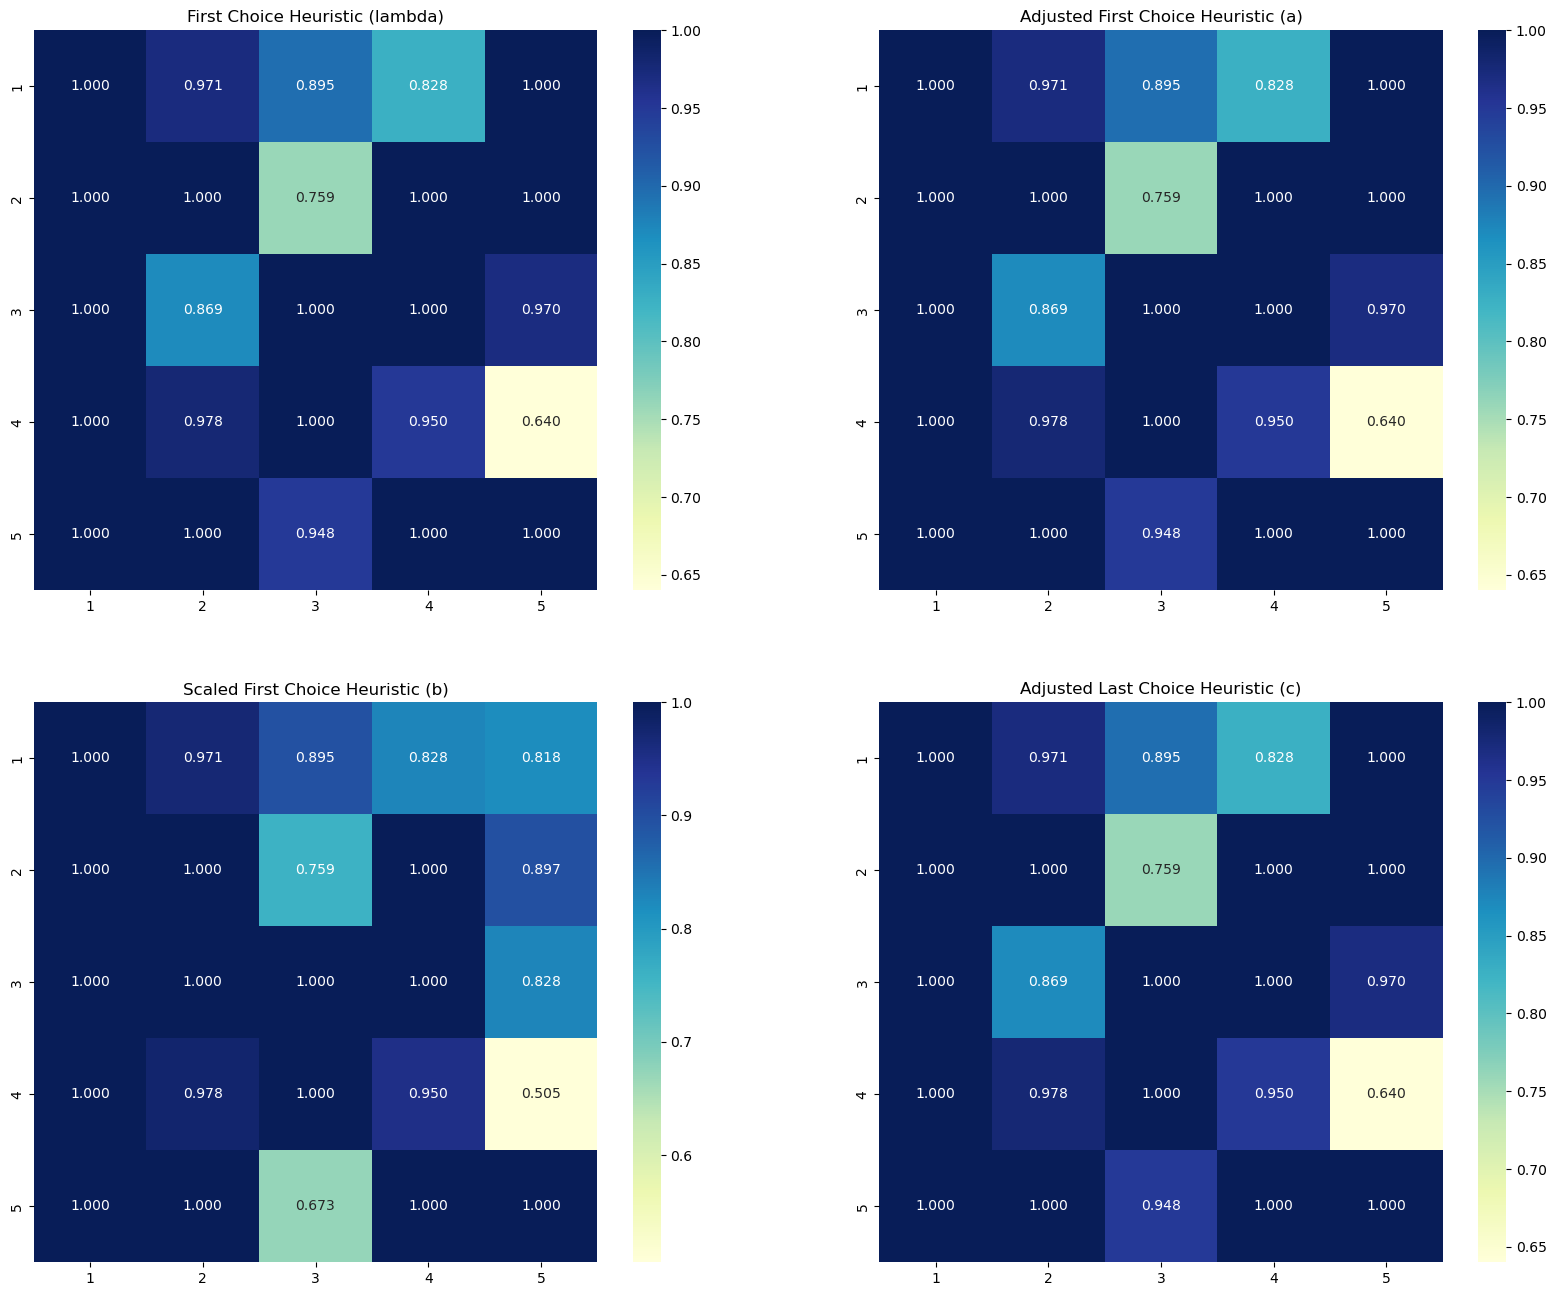

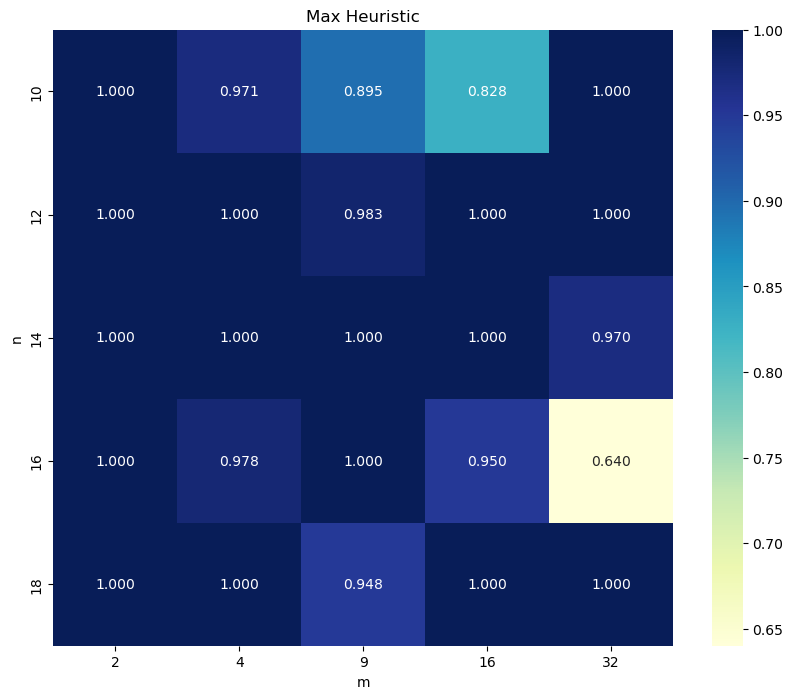

In [111]:
version = 2
capacity = 2
n_values = [1,2,3,4,5]
m_values = [1,2,3,4,5]


first_choice_heuristic_result = np.zeros((5,5))
adjusted_first_choice_heuristic_result = np.zeros((5,5))
scaled_first_choice_heuristic_result = np.zeros((5,5))
adjusted_last_choice_heuristic_result = np.zeros((5,5))
max_heuristic_result = np.zeros((5,5))


for row in range (len(n_values)):
    for col in range(len(m_values)):
        n = n_values[row]
        m = m_values[col]
        NLM_instance = Variants_NLM(m,n)
        if version == 0:
            residual_a = NLM_instance.optimal_result_NL_H_Max()[1] / NLM_instance.optimal_result_NL()
            residual_b = NLM_instance.optimal_result_NL_H_Max()[2] / NLM_instance.optimal_result_NL()
            residual_c = NLM_instance.optimal_result_NL_H_Max()[3] / NLM_instance.optimal_result_NL()
            residual_lambda = NLM_instance.optimal_result_NL_H_Max()[4] / NLM_instance.optimal_result_NL()
            residual_max = NLM_instance.optimal_result_NL_H_Max()[0] / NLM_instance.optimal_result_NL()
        else:
            residual_a = NLM_instance.optimal_result_NL_H_Max(version,capacity)[1] / NLM_instance.optimal_result_NL_brute_force(version,capacity)
            residual_b = NLM_instance.optimal_result_NL_H_Max(version,capacity)[2] / NLM_instance.optimal_result_NL_brute_force(version,capacity)
            residual_c = NLM_instance.optimal_result_NL_H_Max(version,capacity)[3] / NLM_instance.optimal_result_NL_brute_force(version,capacity)
            residual_lambda = NLM_instance.optimal_result_NL_H_Max(version,capacity)[4] / NLM_instance.optimal_result_NL_brute_force(version,capacity)
            residual_max = NLM_instance.optimal_result_NL_H_Max(version,capacity)[0] / NLM_instance.optimal_result_NL_brute_force(version,capacity)

        first_choice_heuristic_result[row][col] = residual_lambda
        adjusted_first_choice_heuristic_result[row][col] = residual_a
        scaled_first_choice_heuristic_result[row][col] = residual_b
        adjusted_last_choice_heuristic_result[row][col] = residual_lambda
        max_heuristic_result[row][col] = residual_max


fig, axs = plt.subplots(2, 2, figsize=(20, 16))


sns.heatmap(first_choice_heuristic_result, annot=True, fmt=".3f", cmap='YlGnBu',
            xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5], ax=axs[0, 0])
axs[0, 0].set_title('First Choice Heuristic (lambda)')

sns.heatmap(adjusted_first_choice_heuristic_result, annot=True, fmt=".3f", cmap='YlGnBu',
            xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5], ax=axs[0, 1])
axs[0, 1].set_title('Adjusted First Choice Heuristic (a)')

sns.heatmap(scaled_first_choice_heuristic_result, annot=True, fmt=".3f", cmap='YlGnBu',
            xticklabels=[1, 2, 3 ,4, 5], yticklabels=[1, 2, 3, 4, 5], ax=axs[1, 0])
axs[1, 0].set_title('Scaled First Choice Heuristic (b)')

sns.heatmap(adjusted_last_choice_heuristic_result, annot=True, fmt=".3f", cmap='YlGnBu',
            xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5], ax=axs[1, 1])
axs[1, 1].set_title('Adjusted Last Choice Heuristic (c)')

plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(max_heuristic_result, annot=True, fmt=".3f", cmap='YlGnBu',
            xticklabels=[2, 4, 9, 16, 32], yticklabels=[10, 12, 14, 16, 18])

plt.title('Max Heuristic')
plt.xlabel('m')
plt.ylabel('n')
plt.show()

        
